## COMP5625M Practical Assessment - Deep Learning [100 Marks]


<div class="logos"><img src="Comp5625M_logo.jpg" width="220px" align="right"></div>

This assessment is divided into two parts:
> 1. Image classification using DNN and CNN [70 Marks]
> 2. Use of RNN to predict texts for image captioning [30 Marks]

The maximum number of marks for each part is shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 50% of the final grade for the module.


### Motivation

Through this coursework, you will:

> 1. Understand and implement your first deep neural network and convolutional neural network (CNN) and see how these can be used for classification problem
> 2. Practice building, evaluating, and finetuning your CNN on an image dataset from development to testing stage.
> 3. You will learn to tackle overfitting problem using strategies such as data augmentation and drop out.
> 4. Compare your model performance and accuracy with others, such as the leaderboard on Kaggle
> 5. Use RNNs to predict the caption of an image from established word vocabularies
> 6. Understand and visualise text predictions for a given image.


### Setup and resources

You must work using this provided template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


Your student username (for example, ```sc15jb```):

sc23b2c

Your full name:

Bofang Chen

### Part I: Image Classification [70 marks]

#### Dataset
This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Direct access of data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[To submit your results on the Kaggle competition. You can also access data here](https://www.kaggle.com/t/9105198471a3490d9057026d27d8a711)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb`` (see the ``note`` below)

``Note:`` If the name is already taken in the Kaggle then please use a similar pseudo name and add a note in your submission with the name you have used in the Kaggle.

#### Submitting your test result to Kaggle leaderboard
The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. More information is provided in the related section below.


## Required packages

[1] [numpy](http://www.numpy.org) is package for scientific computing with python

[2] [h5py](http://www.h5py.org) is package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed some examples for importing some libraries is provided for you below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [ ]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url
from torch.utils.data import random_split

from PIL import Image
import matplotlib.pyplot as plt

import os
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from natsort import natsorted
from torch.utils.data import DataLoader
import csv
import glob
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [ ]:
# always check your version
print(torch.__version__)

2.2.1+cu121


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30.

### **Overview of image classification:**

**1. Function implementation** [14 marks]

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (6 marks)

**2. Model training** [30 marks]
*   **2.1** Training on TinyImageNet30 dataset (6 marks)
*   **2.2** Generating confusion matrices and ROC curves (6 marks)
*   **2.3** Strategies for tackling overfitting (18 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            
**3. Model testing** [10 marks]
*   **3.1**   Testing your final model in (2) on test set - code to do this (4 marks)
*   **3.2**   Uploading your result to Kaggle  (6 marks)

**4. Model Fine-tuning on CIFAR10 dataset** [16 marks]
*   **4.1** Fine-tuning your model (initialise your model with pretrained weights from (2)) (6 marks)
*   **4.2** Fine-tuning model with frozen base convolution layers (6 marks)
*   **4.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe. (4 marks)


<!-- **5. Model comparison** [16 marks]
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (8 marks)
*   **5.2**   Compare the results of your model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks) -->
<!--
**6. Interpretation of results** (14 marks)
*   **6.1** Implement grad-CAM for your model and AlexNet (6 marks)
*   **6.2** Visualise and compare your results from your model and AlexNet (4 marks)
*   **6.3** Provide comment on (4 marks)
    - why the network predictions were correct or not correct in your predictions?
    - what can you do to improve your results further?

**7. Residual connection for deeper network** (9 marks)
*   **7.1** Implement a few residual layers in AlexNet and retrain on TinyImageNet30. You can change network size if you wish. (6 marks)
*   **7.2** Comment on why such connections are important and why this impacted your results in terms of loss and accuracy (if it did!) (3 marks)

**Quality of your report** (2 marks) -->


## 1 Function implementations [14 marks]


### 1.1 Dataset class (4 marks)

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT = '/content/drive/MyDrive/DL'

In [ ]:
# Initialise an empty dictionary
data_map = {}
target_names = []

# open file
with open(ROOT + '/class.txt', mode='r') as file:
    # Reading files with csv.reader
    reader = csv.reader(file, delimiter='\t')

    # Iterate through each line in the file
    for row in reader:
      key = row[1]
      value = row[0]
      data_map[key] = value
      target_names.append(key)

print(data_map)
target_names = tuple(target_names)
print(target_names)

{'baboon': '0', 'banana': '1', 'bee': '2', 'bison': '3', 'butterfly': '4', 'candle': '5', 'cardigan': '6', 'chihuahua': '7', 'elephant': '8', 'espresso': '9', 'fly': '10', 'goldfish': '11', 'goose': '12', 'grasshopper': '13', 'hourglass': '14', 'icecream': '15', 'ipod': '16', 'jellyfish': '17', 'koala': '18', 'ladybug': '19', 'lion': '20', 'mushroom': '21', 'penguin': '22', 'pig': '23', 'pizza': '24', 'pretzel': '25', 'redpanda': '26', 'refrigerator': '27', 'sombrero': '28', 'umbrella': '29'}
('baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella')


In [ ]:
class TestData(Dataset):
  def __init__(self, root_dir, transform):
    # Set the loading directory
    self.root_dir = root_dir
    self.transform = transform
    # List all images in folder and count them
    all_imgs = os.listdir(root_dir)
    self.total_imgs = natsorted(all_imgs)
  def __len__(self):
    # Return the previously computed number of images
    return len(self.total_imgs)
  def __getitem__(self, idx):
    img_loc = os.path.join(self.root_dir, self.total_imgs[idx])

    # Use PIL for image loading
    image = Image.open(img_loc).convert("RGB")
    # Apply the transformations
    tensor_image = self.transform(image)
    return tensor_image, self.total_imgs[idx] # For keep the name which is ImageId

In [ ]:
tf = transforms.Compose([
    transforms.ToTensor(),#Convert the image to a Tensor and normalise the values to [0, 1]
]) #go further in 2.3.1

In [ ]:
class TrainData(Dataset):
  def __init__(self, root_dir, transform, data_map):
    self.root_dir = root_dir
    self.transform = transform
    self.data_map = data_map
    file_list = glob.glob(self.root_dir + "/*")
    print(file_list)
    self.data = []
    for class_path in file_list:
      label = class_path.split("/")[-1]
      for img_path in glob.glob(class_path + "/*.JPEG"):
        self.data.append([img_path, label])
    #self.img_dim = (x,y) #
    #print(self.data)
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    img_path, label = self.data[idx]
    img = cv2.imread(img_path)
    #convert BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, self.img_dim)
    label_id = self.data_map[label]
    label_id = int(label_id)
    #tensor_img = torch.from_numpy(img)
    #tensor_img = tensor_img.permute(2, 0, 1)
    tensor_img = self.transform(img)
    label_id = torch.tensor([label_id])
    return tensor_img, label_id

In [ ]:
test_dataset = TestData(root_dir=ROOT + '/test_set', transform=tf)
test_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=False, num_workers=2)

In [ ]:
print(next(iter(test_dataloader)).shape)
for imgs in test_dataloader:
  print(imgs.shape)

In [ ]:
train_dataset = TrainData(root_dir=ROOT + '/train_set', transform=tf, data_map = data_map)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

['/content/drive/MyDrive/DL/train_set/lion', '/content/drive/MyDrive/DL/train_set/mushroom', '/content/drive/MyDrive/DL/train_set/redpanda', '/content/drive/MyDrive/DL/train_set/pizza', '/content/drive/MyDrive/DL/train_set/umbrella', '/content/drive/MyDrive/DL/train_set/pretzel', '/content/drive/MyDrive/DL/train_set/pig', '/content/drive/MyDrive/DL/train_set/penguin', '/content/drive/MyDrive/DL/train_set/sombrero', '/content/drive/MyDrive/DL/train_set/refrigerator', '/content/drive/MyDrive/DL/train_set/goose', '/content/drive/MyDrive/DL/train_set/jellyfish', '/content/drive/MyDrive/DL/train_set/ladybug', '/content/drive/MyDrive/DL/train_set/icecream', '/content/drive/MyDrive/DL/train_set/koala', '/content/drive/MyDrive/DL/train_set/fly', '/content/drive/MyDrive/DL/train_set/grasshopper', '/content/drive/MyDrive/DL/train_set/goldfish', '/content/drive/MyDrive/DL/train_set/hourglass', '/content/drive/MyDrive/DL/train_set/ipod', '/content/drive/MyDrive/DL/train_set/elephant', '/content/dr

In [ ]:
for imgs, labels in train_dataloader:
    print("Batch of images has shape: ",imgs.shape)
    print("Batch of labels has shape: ", labels.shape)

### 1.2 Define a MLP model class (4 marks)

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [ ]:
# TO COMPLETE
# define a MLP Model class
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, input_size, hidden_sizes, output_size):
    super().__init__()
    layers = []
    layers.append(nn.Flatten())
    layers.append(nn.Linear(input_size, hidden_sizes[0]))
    layers.append(nn.ReLU())
    for i in range(1, len(hidden_sizes)):
      layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
      layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    self.layers = nn.Sequential(*layers)


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

input_size = 64 * 64 * 3
hidden_sizes = [64, 32]
output_size = 30

net_mlp = MLP(input_size, hidden_sizes, output_size)

loss_fn_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.SGD(net_mlp.parameters(), lr=0.001, momentum=0.9)

### 1.3 Define a CNN model class (6 marks)

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers
- Loss function
- Optimiser

*Please note that the network should be at least a few layers for the model to perform well.*

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=128)
    self.fc2 = nn.Linear(128, 30)

    self.flat = nn.Flatten()
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(self.relu(x))
    x = self.conv2(x)
    x = self.pool(self.relu(x))

    x = self.flat(x)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

net_cnn = CNN()
loss_fn_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(net_cnn.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num = 1
for data in train_dataloader:
  if num == 1:
    inputs, labels = data
    print(inputs)
    print(labels)
    break;

tensor([[[[0.1294, 0.1059, 0.1333,  ..., 0.2549, 0.3569, 0.5059],
          [0.1647, 0.1373, 0.1451,  ..., 0.3255, 0.3725, 0.3686],
          [0.2392, 0.2510, 0.2588,  ..., 0.2902, 0.2902, 0.3490],
          ...,
          [0.3569, 0.3608, 0.3765,  ..., 0.1765, 0.2549, 0.4118],
          [0.3412, 0.3490, 0.3647,  ..., 0.3843, 0.4078, 0.4510],
          [0.3020, 0.3137, 0.3373,  ..., 0.3490, 0.3922, 0.3647]],

         [[0.1569, 0.1255, 0.1373,  ..., 0.0941, 0.2118, 0.3686],
          [0.1765, 0.1412, 0.1333,  ..., 0.1725, 0.2353, 0.2431],
          [0.2118, 0.2157, 0.2157,  ..., 0.1569, 0.1647, 0.2314],
          ...,
          [0.2000, 0.2039, 0.2118,  ..., 0.0588, 0.1294, 0.2863],
          [0.1725, 0.1804, 0.1882,  ..., 0.2941, 0.3059, 0.3490],
          [0.1216, 0.1333, 0.1451,  ..., 0.2745, 0.3059, 0.2784]],

         [[0.1255, 0.0980, 0.1137,  ..., 0.1255, 0.2431, 0.3961],
          [0.1412, 0.1098, 0.1059,  ..., 0.1922, 0.2588, 0.2627],
          [0.1804, 0.1882, 0.1922,  ..., 0

## 2 Model training [30 marks]


### 2.1 Train both MLP and CNN model - show loss and accuracy graphs side by side (6 marks)

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. A top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [ ]:
results_path = ROOT+'results/'
os.makedirs(results_path, exist_ok = True)
#saveCkpt_mlp = results_path+ 'cnninit.pt'
#saveCkpt_cnn = results_path+ 'mlp.pt'

In [ ]:
statsrec_mlp = {}
statsrec_cnn = {}

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

tr_loader = DataLoader(tr_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=2)

#patience = 5  # The number of epochs to tolerate,
best_val_loss = np.inf
patience_counter = 0

In [ ]:
num = 1
for data in tr_loader:
  if num == 1:
    inputs, labels = data
    print(inputs)
    print(labels)
    break;

tensor([[[[0.0196, 0.0000, 0.0392,  ..., 0.0157, 0.0157, 0.0118],
          [0.0000, 0.0235, 0.0000,  ..., 0.0118, 0.0078, 0.0078],
          [0.0000, 0.0235, 0.0000,  ..., 0.0078, 0.0078, 0.0039],
          ...,
          [0.8000, 0.8157, 0.8314,  ..., 0.0863, 0.1059, 0.1098],
          [0.7843, 0.7961, 0.8118,  ..., 0.0549, 0.0824, 0.1020],
          [0.7647, 0.7804, 0.7961,  ..., 0.0235, 0.0549, 0.0902]],

         [[0.0471, 0.0039, 0.0667,  ..., 0.0431, 0.0431, 0.0392],
          [0.0000, 0.0510, 0.0000,  ..., 0.0471, 0.0431, 0.0431],
          [0.0235, 0.0471, 0.0000,  ..., 0.0510, 0.0510, 0.0471],
          ...,
          [0.7961, 0.8118, 0.8275,  ..., 0.1843, 0.1961, 0.2078],
          [0.7843, 0.7961, 0.8118,  ..., 0.1608, 0.1804, 0.2078],
          [0.7647, 0.7804, 0.7961,  ..., 0.1294, 0.1608, 0.1961]],

         [[0.0863, 0.0431, 0.1059,  ..., 0.1569, 0.1569, 0.1529],
          [0.0471, 0.0902, 0.0471,  ..., 0.1608, 0.1569, 0.1569],
          [0.0784, 0.0941, 0.0549,  ..., 0

In [ ]:
def stats(loader, net, loss_fn, topk=(1,)):
  net.eval()
  all_outputs = []
  all_targets = []
  correct = 0
  total = 0
  running_loss = 0
  n = 0    # counter for number of minibatches
  with torch.no_grad():
    for data in loader:
      images, labels = data

      #to work with gpu you will need to load data and labels to gpu
      images = images.to(device)
      labels = labels.to(device)
      labels = labels.squeeze(dim=1)
      outputs = net(images).to(device)

      # accumulate loss
      running_loss += loss_fn(outputs, labels)
      n += 1

      # Accumulate outputs and targets
      all_outputs.append(outputs)
      all_targets.append(labels)

    # Concatenate all outputs and targets
    # Convert them to tensor as one-dimensional
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute top-k accuracy
    topk_acc = topk_accuracy(all_outputs, all_targets, topk=topk)

  return running_loss/n, topk_acc

In [ ]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)): #output should be tensor
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def show(data, path):
  statsrec = data["stats"]
  fig, ax1 = plt.subplots()
  plt.plot(statsrec['train_losses'], 'r', label = 'training loss', )
  plt.plot(statsrec['val_losses'], 'g', label = 'val loss' )
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training and test loss, and topks')
  ax2=ax1.twinx()
  for k in statsrec['train_topk'].keys():
    ax2.plot(statsrec['train_topk'][k], label=f'Train Top-{k} Accuracy')
    ax2.plot(statsrec['val_topk'][k], '--', label=f'Val Top-{k} Accuracy')
  #ax2.plot(statsrec['train_topk'], 'm', label = 'training topk')
  #ax2.plot(statsrec['val_topk'], 'b', label = 'val topk')
  ax2.set_ylabel('topks')
  plt.legend(loc='upper right')
  fig.savefig(ROOT + "/pictures/" + path +".svg")
  plt.show()

In [ ]:
def MLP_train(num, net, train_dataloader, val_loader, loss_fn, optimizer, patience, save_path, topk=(1,)):
  nepochs = num #number of epochs
  best_val_loss = np.inf
  patience_counter = 0
  saveCkpt_mlp = results_path + save_path

  # record performance
  # store the mean loss in each epoch
  losses, losses_val = np.zeros(nepochs), np.zeros(nepochs)
  # Store top-k accuracy for each epoch
  topk_accuracy_epochs, topk_accuracy_epochs_val = {k: [] for k in topk}, {k: [] for k in topk}

  #To work with GPU
  net = net.to(device)

  for epoch in range(nepochs):
    running_loss = 0.0
    n = 0
    # Accumulate batch outputs and targets for top-k accuracy computation
    all_outputs = []
    all_targets = []
    for data in train_dataloader:
    #Get data and work with GPU
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      labels = labels.squeeze(dim=1)
      #Zero the parameter gradients
      optimizer.zero_grad()
      #Forward, backward, and update parameters
      outputs = net(inputs).to(device)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      #accumulate loss
      running_loss += loss.item()
      n += 1
      # Accumulate outputs and targets
      all_outputs.append(outputs)
      all_targets.append(labels)

    # Concatenate all outputs and targets
    # Convert them to tensor as one-dimensional
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # topk_accuracy and losses for this epoch in the training
    # Compute top-k accuracy
    topk_acc = topk_accuracy(all_outputs, all_targets, topk=topk)
    for i, k in enumerate(topk):
      topk_accuracy_epochs[k].append(topk_acc[i].item())# Convert tensors to numbers
    # record the mean loss for this epoch
    losses[epoch] = running_loss / n # return? or save to device

    # topk_accuracy and losses for this epoch in the testing
    loss_val, topk_acc_val = stats(val_loader, net, loss_fn, topk=topk)
    for i, k in enumerate(topk):
      topk_accuracy_epochs_val[k].append(topk_acc_val[i].item())# item():Convert tensors to numbers
    losses_val[epoch] = loss_val

    if loss_val < best_val_loss:
      best_val_loss = loss_val
      patience_counter = 0
      #save : torch.save(net.state_dict(), 'best_model.pt')
      statsrec_mlp = {
          'train_losses': losses,
          'val_losses': losses_val,
          'train_topk': topk_accuracy_epochs,
          'val_topk': topk_accuracy_epochs_val,
      }
      torch.save({
          "state_dict": net.state_dict(),
          "stats": statsrec_mlp
          }, saveCkpt_mlp)
      #losses_end = np.vstack([losses, losses_val])
      #topk_end = np.vstack([topk_accuracy_epochs, topk_accuracy_epochs_val])
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print("Training stopped.")
        break
  #combine loss and topk separately
  #losses_end = np.vstack([losses, losses_val])
  #topk_end = np.vstack([topk_accuracy_epochs, topk_accuracy_epochs_val])
  statsrec_mlp = {
          'train_losses': losses,
          'val_losses': losses_val,
          'train_topk': topk_accuracy_epochs,
          'val_topk': topk_accuracy_epochs_val,
      }
  torch.save({
          "state_dict": net.state_dict(),
          "stats": statsrec_mlp
          }, saveCkpt_mlp)

In [ ]:
MLP_train(30, net_mlp, tr_loader, val_loader, loss_fn_mlp, optimizer_mlp, 10, 'mlp.pt', topk=(1,))

Training stopped.


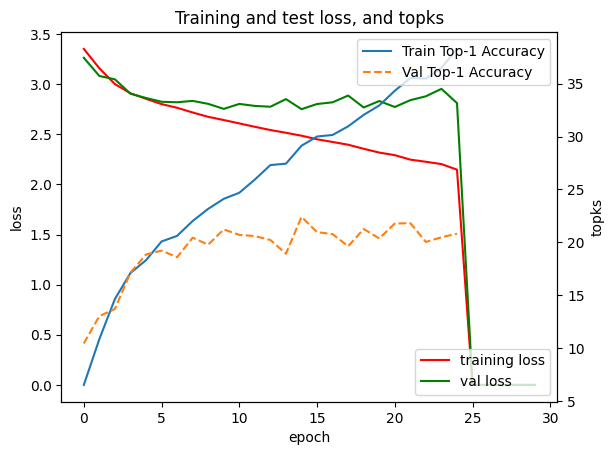

In [ ]:
# Your graph
mlp_pt = 'mlp.pt'
results_path = ROOT + 'results/' + mlp_pt
data_mlp_plt = torch.load(results_path, map_location=device) # by doing map_location=device, you can use trained model on GPU --> to test on CPU
show(data_mlp_plt,'mlp')

In [ ]:
def CNN_train(num, net, train_loader, val_loader, loss_fn, optimizer, patience, save_path, topk):
  nepochs = num #number of epochs
  #patience
  best_val_loss = np.inf
  patience_counter = 0

  saveCkpt_cnn = save_path

  # record performance
  # store the mean loss in each epoch
  losses, losses_val = np.zeros(nepochs), np.zeros(nepochs)

  # Store top-k accuracy for each epoch
  topk_accuracy_epochs, topk_accuracy_epochs_val = {k: [] for k in topk}, {k: [] for k in topk}

  #to work with gpu
  net = net.to(device)

  for epoch in range(nepochs):
    running_loss = 0.0   # accumulated loss
    n = 0                # number of minibatches
    all_outputs = []
    all_targets = []
    for data in train_loader:
      inputs, labels = data
      #to work with gpu you will need to load data and labels to gpu
      inputs = inputs.to(device)
      labels = labels.to(device)
      #labels = labels.squeeze()
      labels = labels.squeeze(dim=1)
      #labels = torch.squeeze(labels)
      # Zero the parameter gradients
      optimizer.zero_grad()
      # Forward, backward, and update parameters
      outputs = net(inputs).to(device) # note: .to(device) helps to load data to your gpu
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      # accumulate loss
      running_loss += loss.item()
      n += 1
      # Accumulate outputs and targets
      all_outputs.append(outputs)
      all_targets.append(labels)

    # Concatenate all outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # topk_accuracy and losses for this epoch in the training
    # Compute top-k accuracy
    topk_acc = topk_accuracy(all_outputs, all_targets, topk=topk)
    for i, k in enumerate(topk):
      topk_accuracy_epochs[k].append(topk_acc[i].item())# Convert tensors to numbers
    # record the mean loss for this epoch
    losses[epoch] = running_loss / n # return? or save to device

    # topk_accuracy and losses for this epoch in the testing
    loss_val, topk_acc_val = stats(val_loader, net, loss_fn, topk=topk)
    for i, k in enumerate(topk):
      topk_accuracy_epochs_val[k].append(topk_acc_val[i].item())# item():Convert tensors to numbers
    losses_val[epoch] = loss_val

    #maybe another method
    if loss_val < best_val_loss:
      best_val_loss = loss_val
      patience_counter = 0
      #save : torch.save(net.state_dict(), 'best_model.pt') # if nothing changed one time would be fine
      statsrec_cnn = {
          'train_losses': losses,
          'val_losses': losses_val,
          'train_topk': topk_accuracy_epochs,
          'val_topk': topk_accuracy_epochs_val,
      }
      torch.save({
          "state_dict": net.state_dict(),
          "stats": statsrec_cnn
          }, saveCkpt_cnn)
      #losses_end = np.vstack([losses, losses_val])
      #topk_end = np.vstack([topk_accuracy_epochs, topk_accuracy_epochs_val])
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print("Training stopped.")
        break
  #losses_end = np.vstack([losses, losses_val])
  #topk_end = np.vstack([topk_accuracy_epochs, topk_accuracy_epochs_val])
  statsrec_cnn = {
          'train_losses': losses,
          'val_losses': losses_val,
          'train_topk': topk_accuracy_epochs,
          'val_topk': topk_accuracy_epochs_val,
      }
  torch.save({
          "state_dict": net.state_dict(),
          "stats": statsrec_cnn
          }, saveCkpt_cnn)

In [ ]:
statsrec_cnn = {}
CNN_train(30, net_cnn, tr_loader, val_loader, loss_fn_cnn, optimizer_cnn, 10, ROOT+'results/' + 'cnninit.pt', topk=(1,))

Training stopped.


In [ ]:
cnninit_pt = 'cnninit.pt'
results_path = ROOT+'results/'+ cnninit_pt
data_cnn_plt = torch.load(results_path, map_location=device)
statsrec = data_cnn_plt['stats']
print(type(statsrec['val_losses']))
print(statsrec['val_losses'])
print(type(statsrec['train_topk']))
print(statsrec['train_topk'])

<class 'numpy.ndarray'>
[3.25201082 2.94064498 2.78614759 2.53576803 2.45113373 2.38329625
 2.34746122 2.29955482 2.22959733 2.19431186 2.21426606 2.19301462
 2.32249618 2.26616502 2.33576512 2.39906001 2.50105047 2.70344448
 2.89160848 3.13425779 3.27658844 3.59975576 0.         0.
 0.         0.         0.         0.         0.         0.        ]
<class 'dict'>
{1: [6.972222328186035, 13.240740776062012, 19.509260177612305, 25.129629135131836, 29.657407760620117, 33.26852035522461, 36.21296310424805, 38.64814758300781, 41.814815521240234, 45.175926208496094, 47.75925827026367, 51.185184478759766, 55.092594146728516, 59.4444465637207, 63.53703689575195, 68.62036895751953, 72.54629516601562, 77.91666412353516, 82.3888931274414, 87.06481170654297, 90.71296691894531, 93.94444274902344]}


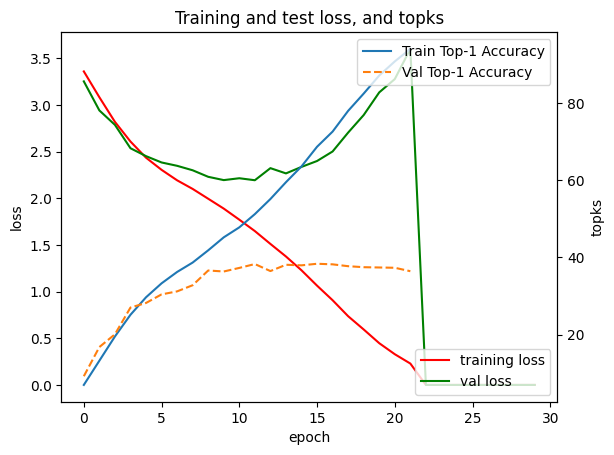

In [ ]:
cnninit_pt = 'cnninit.pt'
results_path = ROOT+'results/'+ cnninit_pt
data_cnn_plt = torch.load(results_path, map_location=device)
show(data_cnn_plt,'cnninit')

> Comment on your model and the results you have obtained. This should include the number of parameters for each of your models and briefly explain why one should use CNN over MLP for the image classification problem.

For MLP model: mlp model contains three parameters, input layer, hidden layer and output layer.

Input layer to first hidden layer : 64×64×3×64+64=786,496

First hidden layer to second hidden layer : 64×32+32 = 2080

Second hidden layer to the output layer : 32×30+30 = 990

Total trainable parameter : 786,496+2,080+990=789,566


For CNN model: cnn model contains 2 convolutional layers, 2 fully connected layers. Each convolutional layer has a convolutional kernel of 3 and a boundary padding of 1.
And after each convolutional layer, it goes through activation function ReLU() and pooling layer (kernel_size=2, stride=2).

conv1 layer:Number of input channels = 3, Number of output channels = 32, Convolutional kernel size = 3x3
Number of parameters = (3^2 x 3 + 1) x 32 = 896

conv2 layer: Number of input channels = 32, Number of output channels = 64, Convolution kernel size = 3x3
Number of parameters = (3^2 x 32 + 1) x 64 = 18496

fc1 layer: Number of input features = 64 x 16 x 16, Number of output features = 128
Number of parameters = 64 x 16 x 16 x 128 + 128 = 2,097,280

fc2 layer: Number of input features = 128, Number of output features = 30
Number of parameters =  128 x 30 + 30 = 3870

Total : 896+18,496+2,097,280+3,870=2,120,542

For the loss function and optimiser, both models are using both CrossEntropyLoss() method combining Softmax activation function and cross-entropy loss, and Stochastic Gradient Descent optimiser.

There are two images that show that, firstly, in terms of Loss, the mlp model does not have a significant and slow decrease in loss, but the cnn model has a more significant decrease in losss. Mainly, in terms of accuracy, the cnn model is significantly more accurate than the mlp model.
Moreover, the mlp model triggered the early stopping mechanism and had a low accuracy rate, which proved that the model needed further adjustment to improve the training process. However, for the same number of rounds, the phenotype of the cnn model was significantly better than that of the mlp model, and it has more potential for further improvement.

### 2.2 Generating confusion matrix and ROC curves (6 marks)
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.
- Display an ROC curve for the two top and two bottom classes with area under the curve

In [ ]:
net = net_cnn
saveCkpt_cnn = ROOT+'results/' + 'cnninit.pt'
net.load_state_dict(torch.load(saveCkpt_cnn)['state_dict'])
#data_show_mlp = data_mlp_plt
data_show_cnn = data_cnn_plt
net.eval()  # Set to evaluation mode

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=30, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
)

In [ ]:
def get_pred_and_labels(model, loader):
    all_predictions = []
    all_labels = []
    all_probs = []
    all_true_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).squeeze(dim=1)

            outputs = model(images)
            #Find the highest scoring category index from the category scores of each sample output by the model
            _, predictions = torch.max(outputs, 1)
            #The probability of each category output by applying the softmax function model
            probs = torch.softmax(outputs, dim=1)
            #confusion_matrix
            #all_predictions : Index of most likely categories
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            #Multi-classification ROC
            all_probs.extend(probs.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    #np.array : Converting a list containing multiple arrays into a single, contiguous NumPy array
    #np.squeeze : Remove all dimensions of 1 in the array shape
    return np.array(all_predictions), np.squeeze(np.array(all_labels)), np.array(all_probs), np.array(all_true_labels)

In [ ]:
train_preds, train_labels, train_probs, train_true_labels= get_pred_and_labels(net, tr_loader)
val_preds, val_labels,val_probs, val_true_labels= get_pred_and_labels(net, val_loader)
#Converting a multiclassification into multiple dichotomies, which means one-hoting coding.
train_true_labels = label_binarize(train_true_labels, classes=range(len(target_names)))
val_true_labels = label_binarize(val_true_labels, classes=range(len(target_names)))

In [ ]:
def plot_confusion_matrix_1(labels, preds, title, target_names):
    cm = confusion_matrix(labels, preds, normalize='true')
    plt.figure(figsize=(40, 40))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Display data scaling in each grid
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f'),
                     horizontalalignment="center",
                     color="black" if cm[i, j] < 0.5 else "white")

    plt.show()

In [ ]:
def plot_confusion_matrix(labels, preds, title, target_names):
    cm = confusion_matrix(labels, preds, normalize='true')
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(target_names)))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

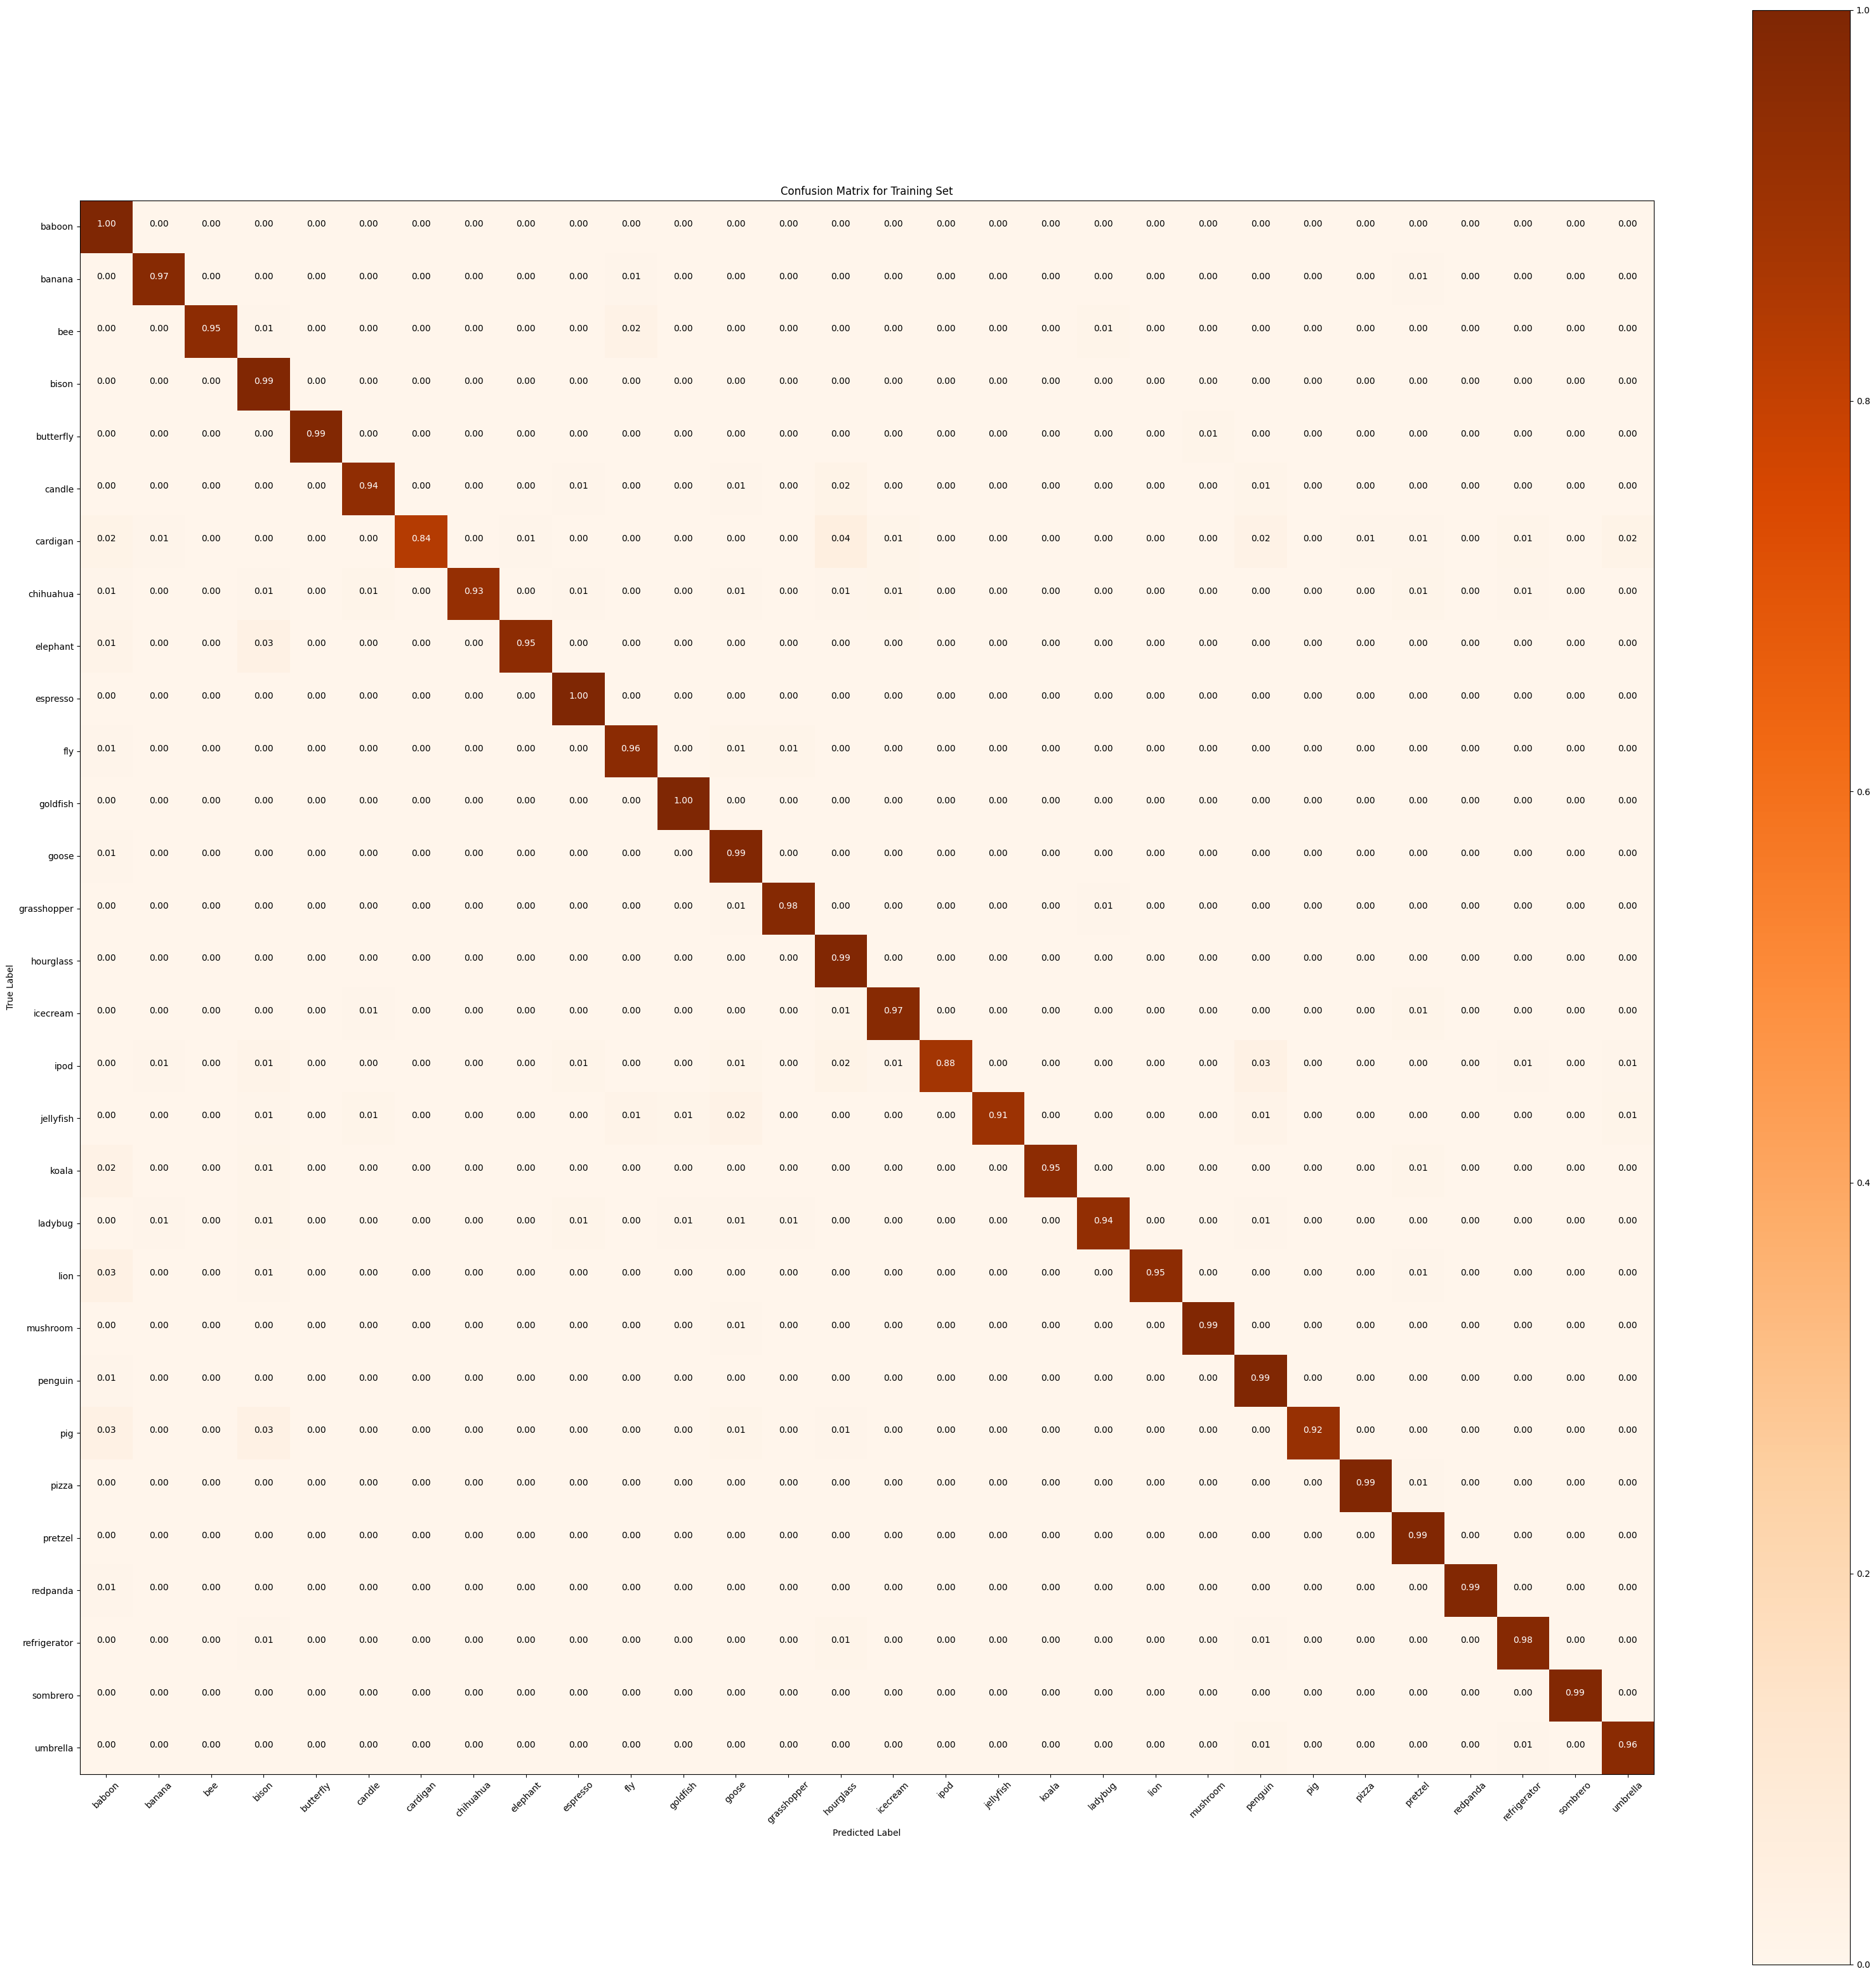

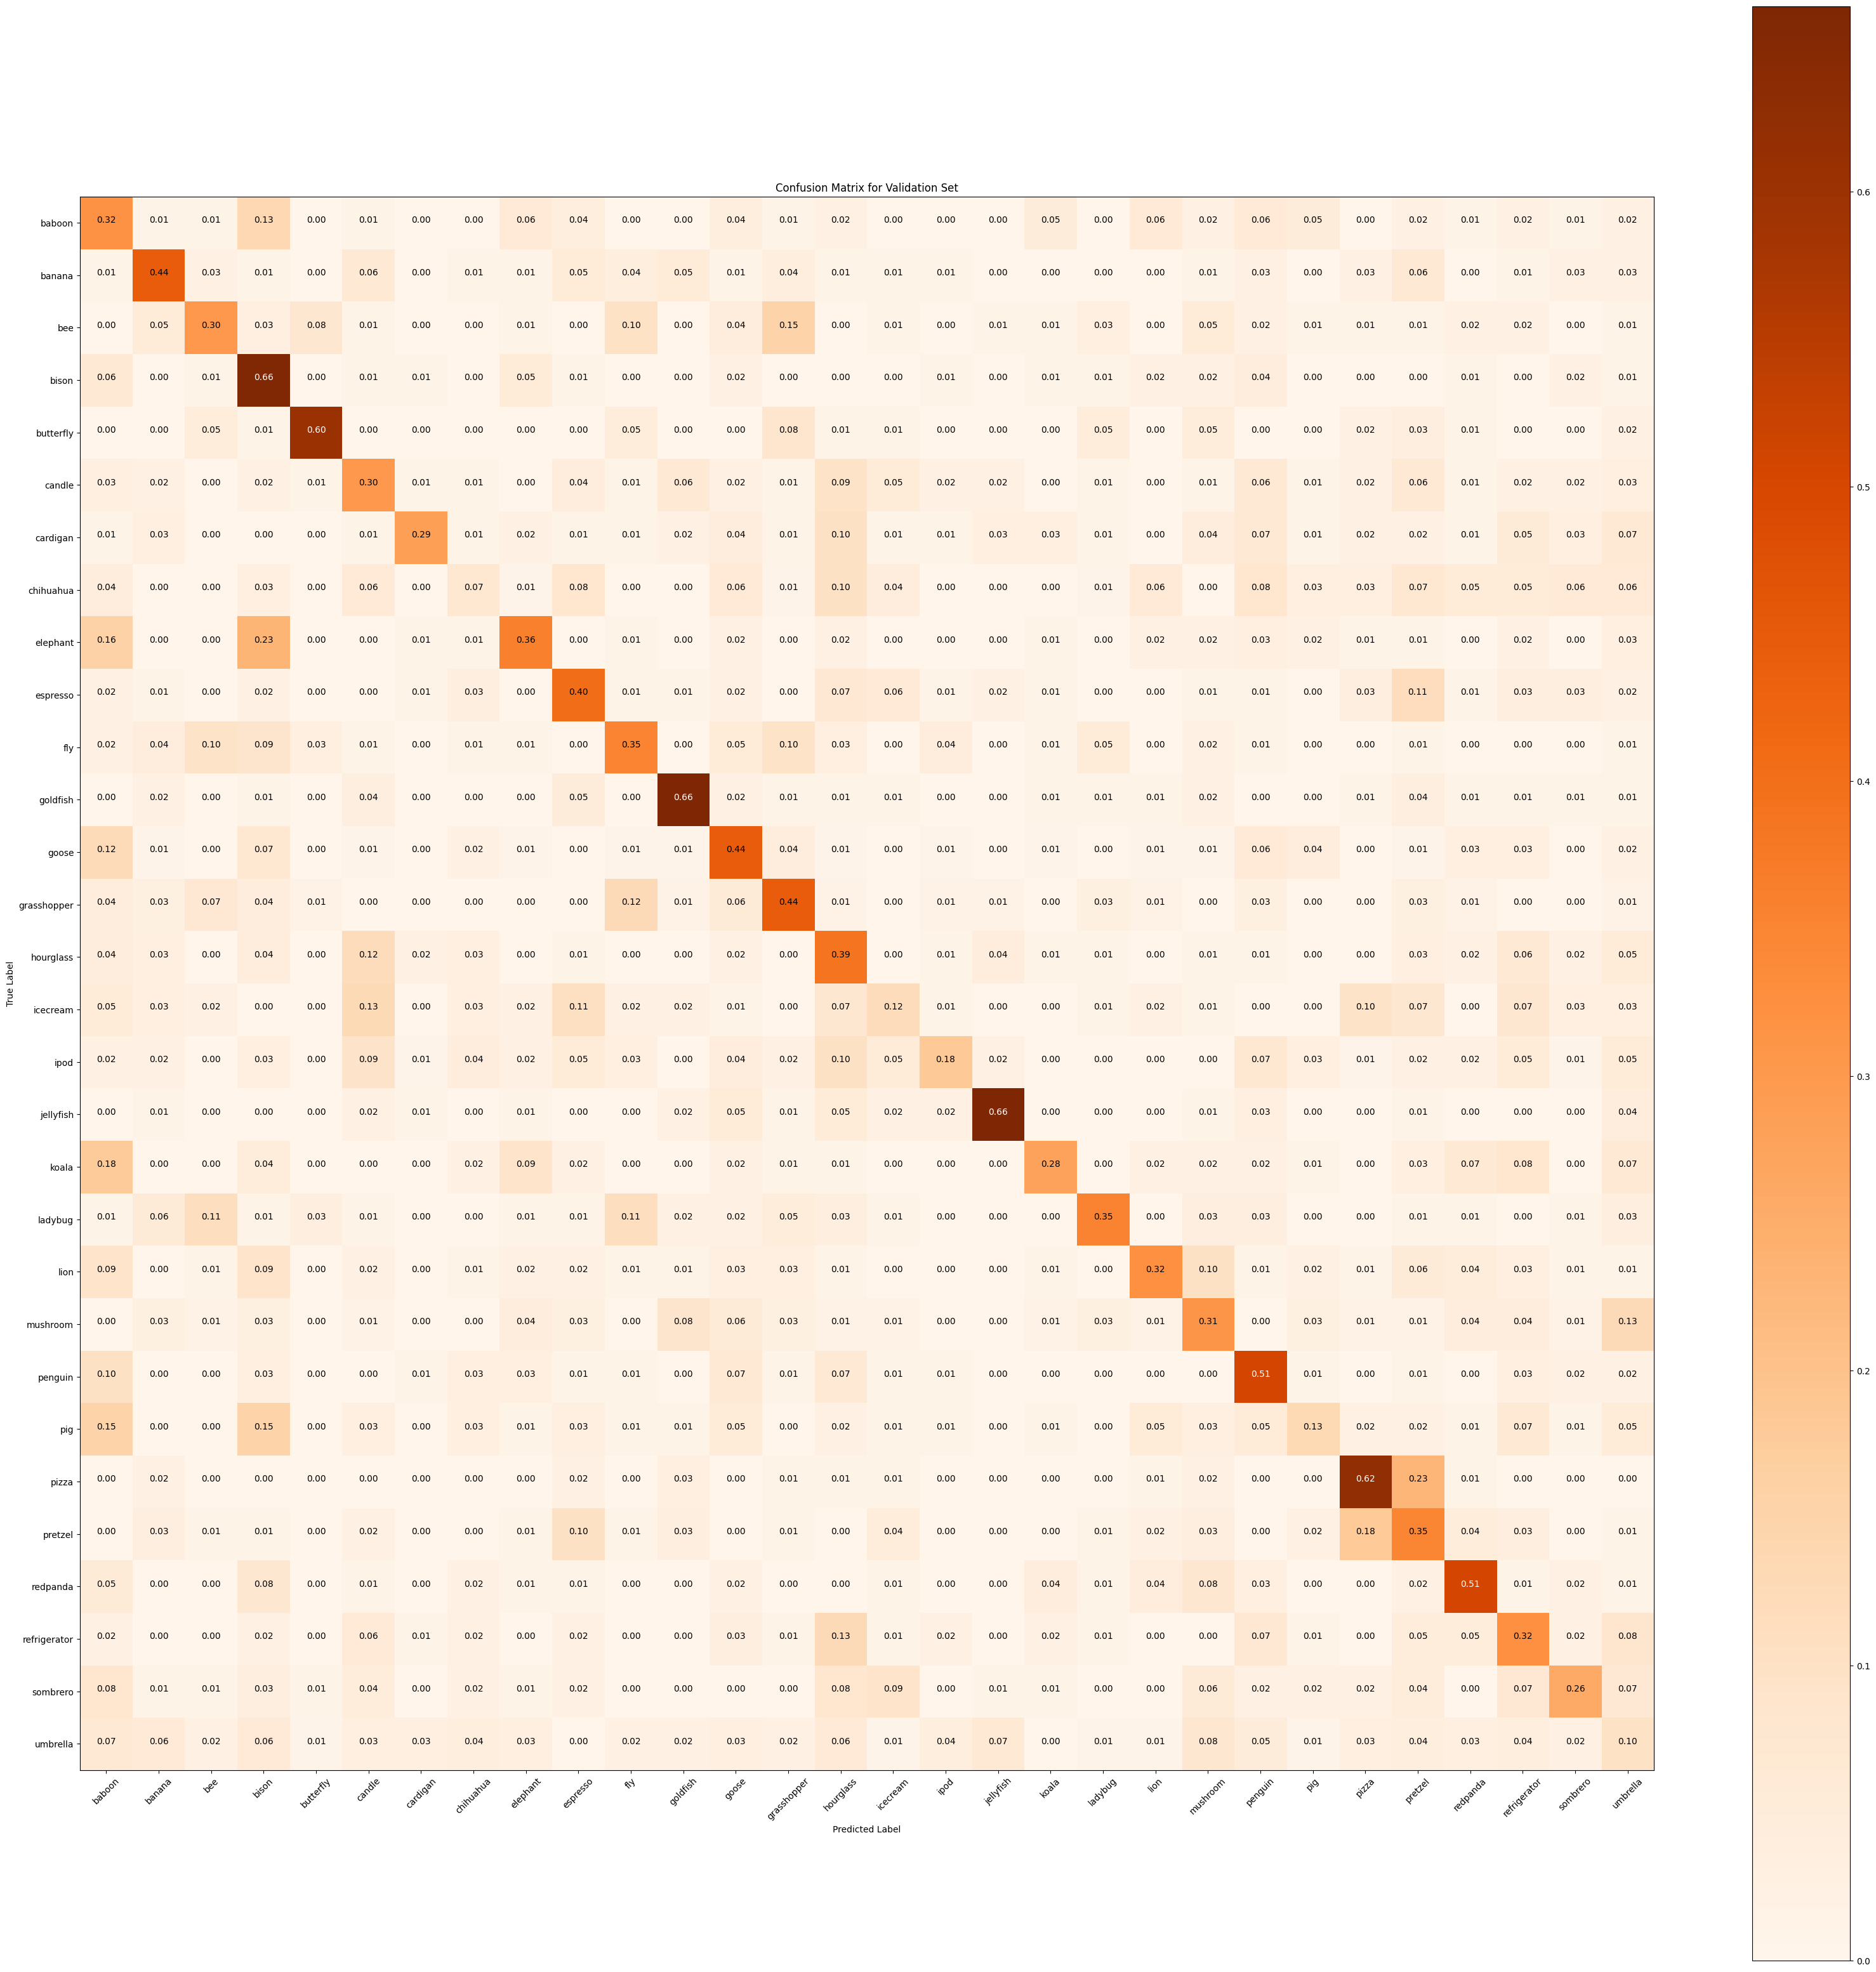

In [ ]:
plot_confusion_matrix_1(train_labels, train_preds, 'Confusion Matrix for Training Set', target_names)
plot_confusion_matrix_1(val_labels, val_preds, 'Confusion Matrix for Validation Set', target_names)

In [ ]:
def sorted_classes(all_true_labels, all_probs):
  auc_scores = []
  for i in range(len(target_names)):
    fpr, tpr, _ = roc_curve(all_true_labels[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

  auc_scores = np.array(auc_scores)
  sorted_indices = np.argsort(auc_scores)
  return sorted_indices

In [ ]:
sorted_train = sorted_classes(train_true_labels, train_probs)

In [ ]:
sorted_val = sorted_classes(val_true_labels, val_probs)

In [ ]:
#top_two_classes = sorted_indices[-2:]
##bottom_two_classes = sorted_indices[:2]
#classes_of_interest = np.concatenate([top_two_classes, bottom_two_classes])

In [ ]:
def draw_ROC(all_true_labels, all_probs, sorted_indices):
  top_two_classes = sorted_indices[-2:]
  bottom_two_classes = sorted_indices[:2]
  classes_of_interest = np.concatenate([top_two_classes, bottom_two_classes])
  for i in classes_of_interest:
      fpr, tpr, _ = roc_curve(all_true_labels[:, i], all_probs[:, i])
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, lw=2, label='Class %d (AUC = %0.2f)' % (i, roc_auc))

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Top 2 and Bottom 2 Classes by AUC')
  plt.legend(loc="lower right")
  plt.show()


 # print("Top two classes (by AUC):", top_two_classes)
 # print("Bottom two classes (by AUC):", bottom_two_classes)

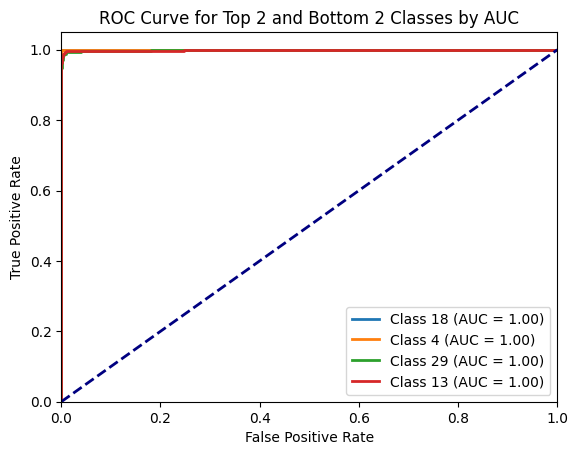

In [ ]:
draw_ROC(train_true_labels, train_probs, sorted_train)

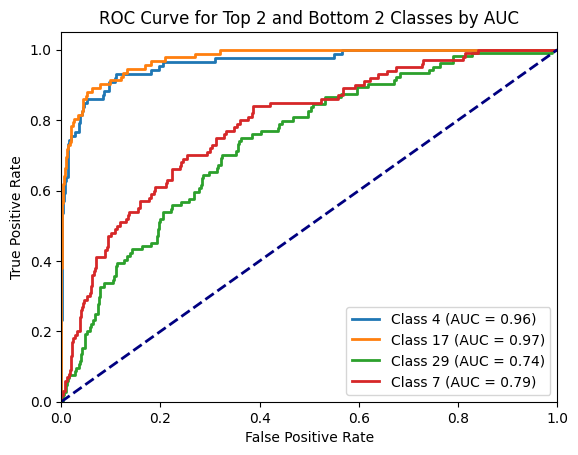

In [ ]:
draw_ROC(val_true_labels, val_probs, sorted_val)

### Redesign your CNN model (optional)
> This is optional and does not carry any marks. Often to tackle model underfitting we tend to make more complex network design. Depending on your observation, you can improve your model if you wish.

In [ ]:
# Your code here (optional)

**Note: All questions below here relates to the CNN model only and not an MLP model! You are advised to use your final CNN model only for each of the questions below.**

### 2.3 Strategies for tackling overfitting (18 marks)
Using your (final) CNN model perform the strategies below to avoid overfitting problems. You can resuse the network weights from previous training, often referred to as ``fine tuning``.
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

> Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation (6 marks)

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations.

> Provide graphs and comment on what you observe.


In [ ]:
def print_num(data_cnn_plt):
  statsrec = data_cnn_plt['stats']
  print(type(statsrec['val_losses']))
  print(statsrec['val_losses'])
  print(type(statsrec['val_topk']))
  print(statsrec['val_topk'])
  print(type(statsrec['val_losses']))
  print(statsrec['train_losses'])
  print(type(statsrec['val_topk']))
  print(statsrec['train_topk'])

In [ ]:
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2), #Photometric
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),#geometric
    transforms.RandomHorizontalFlip(p=0.5),#geometric
    transforms.RandomRotation(degrees=15),#geometric
    transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),# photometric
])

In [ ]:
trainset_aug = TrainData(root_dir=ROOT + '/train_set', transform=trnsfrm, data_map = data_map)
trainloader_aug = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=2)

['/content/drive/MyDrive/DL/train_set/lion', '/content/drive/MyDrive/DL/train_set/mushroom', '/content/drive/MyDrive/DL/train_set/redpanda', '/content/drive/MyDrive/DL/train_set/pizza', '/content/drive/MyDrive/DL/train_set/umbrella', '/content/drive/MyDrive/DL/train_set/pretzel', '/content/drive/MyDrive/DL/train_set/pig', '/content/drive/MyDrive/DL/train_set/penguin', '/content/drive/MyDrive/DL/train_set/sombrero', '/content/drive/MyDrive/DL/train_set/refrigerator', '/content/drive/MyDrive/DL/train_set/goose', '/content/drive/MyDrive/DL/train_set/jellyfish', '/content/drive/MyDrive/DL/train_set/ladybug', '/content/drive/MyDrive/DL/train_set/icecream', '/content/drive/MyDrive/DL/train_set/koala', '/content/drive/MyDrive/DL/train_set/fly', '/content/drive/MyDrive/DL/train_set/grasshopper', '/content/drive/MyDrive/DL/train_set/goldfish', '/content/drive/MyDrive/DL/train_set/hourglass', '/content/drive/MyDrive/DL/train_set/ipod', '/content/drive/MyDrive/DL/train_set/elephant', '/content/dr

In [ ]:
traug_size = int(0.8 * len(trainset_aug))
valaug_size = len(trainset_aug) - traug_size

traug_dataset, valaug_dataset = random_split(trainset_aug, [traug_size, valaug_size])

traug_loader = DataLoader(traug_dataset, batch_size=16, shuffle=True, num_workers=2)
valaug_loader = DataLoader(valaug_dataset, batch_size=24, shuffle=False, num_workers=2)

In [ ]:
net_aug = net_cnn
#saveCkpt_cnn = ROOT+'results/' + 'cnninit.pt'
#net_aug.load_state_dict(torch.load(saveCkpt_cnn)['state_dict'])

In [ ]:
statsrec_cnn = {}
CNN_train(30, net_aug, traug_loader, valaug_loader, loss_fn_cnn, optimizer_cnn, 10, ROOT+'results/' + 'cnnaug.pt', topk=(1,))

Comments : By using five different data enhancement methods, we obtained the following images.

Through the image, we can find:

Firstly, the highest accuracy of val is higher than the previous initial model.

Secondly, for the training part, the overfitting problem is well mitigated, which proves that the recognition ability of the model can be improved by transforming the photometric and geometric position of the image.

In the future, more training sessions may be needed to better represent the highest accuracy the model can achieve.

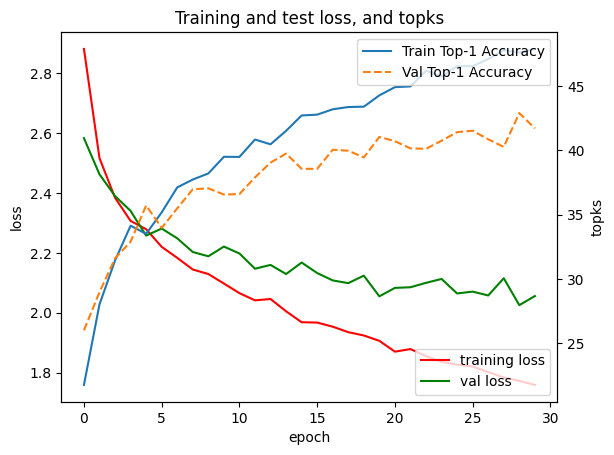

In [ ]:
# use previous method to show??
cnnaug_pt = 'cnnaug.pt'
results_path = ROOT+'results/'+ cnnaug_pt
data_cnnaug_plt = torch.load(results_path, map_location=device)
show(data_cnnaug_plt,'cnnaug')

In [ ]:
print_num(data_cnnaug_plt)

<class 'numpy.ndarray'>
[2.58268023 2.46188307 2.38956094 2.33989525 2.25750017 2.28105283
 2.2483983  2.20271921 2.18848538 2.22086954 2.197891   2.14700627
 2.15962958 2.12925887 2.16758776 2.1324966  2.10794353 2.09889865
 2.12388539 2.05484152 2.08306026 2.08518028 2.0999217  2.11289573
 2.06444597 2.07057023 2.05772138 2.11511207 2.02539682 2.05574822]
<class 'dict'>
{1: [26.0, 28.962963104248047, 31.592592239379883, 32.88888931274414, 35.703704833984375, 33.96296310424805, 35.481483459472656, 36.96296310424805, 37.03703689575195, 36.55555725097656, 36.592594146728516, 37.88888931274414, 39.03703689575195, 39.74074172973633, 38.55555725097656, 38.55555725097656, 40.03703689575195, 39.96296310424805, 39.4444465637207, 41.03703689575195, 40.703704833984375, 40.14814758300781, 40.11111068725586, 40.74074172973633, 41.407405853271484, 41.51852035522461, 40.85185241699219, 40.25925827026367, 42.88888931274414, 41.703704833984375]}
<class 'numpy.ndarray'>
[2.88046357 2.51598917 2.383741

#### 2.3.2 Dropout (6 marks)

> Implement dropout in your model

> Provide graphs and comment on your choice of proportion used.

In [ ]:
# Your code here!
torch.manual_seed(0)
np.random.seed(0)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

tr_loader = DataLoader(tr_dataset, batch_size=8, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=2)

#patience = 5  # The number of epochs to tolerate,
best_val_loss = np.inf
patience_counter = 0

In [ ]:

class CNN_2_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=128)
    self.fc2 = nn.Linear(128, 30)

    self.dropout = nn.Dropout(p=0.5) #The Dropout ratio is set to 0.5, meaning that half of the neurons in each training step are randomly dropped.

    self.flat = nn.Flatten()
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(self.relu(x))
    x = self.conv2(x)
    x = self.pool(self.relu(x))

    x = self.flat(x)
    x = self.relu(self.fc1(x))

    x = self.dropout(x)

    x = self.fc2(x)
    return x

net_drop = CNN_2_2()
loss_fn_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(net_drop.parameters(), lr=0.001, momentum=0.9)

In [ ]:
statsrec_cnn = {}
CNN_train(30, net_drop, tr_loader, val_loader, loss_fn_cnn, optimizer_cnn, 10, ROOT+'results/' + 'cnndrop.pt', topk=(1,))

Training stopped.


The Dropout ratio is set to 0.5, meaning that half of the neurons in each training step are randomly dropped. This is a very common parameter.

But through the model, it does not significantly improve the performance, and even reduced a little, and also triggered the early stopping mechanism, the follow-up may need to increase the number of training times, or try other ratios similar to 0.2,0.3 and so on.

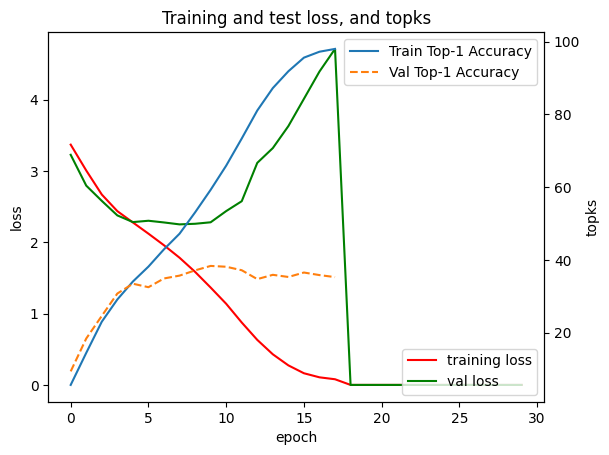

In [ ]:
cnndrop_pt = 'cnndrop.pt'
results_path = ROOT+'results/'+ cnndrop_pt
data_cnndrop_plt = torch.load(results_path, map_location=device)
show(data_cnndrop_plt,'cnndrop')

#### 2.3.3 Hyperparameter tuning (6 marks)

> Use learning rates [0.1, 0.001, 0.0001].

> Provide graphs each for loss and accuracy at three different learning rates in a single graph.

In [ ]:
# Your code here!
net_hyp = net_cnn
loss_fn_cnn = nn.CrossEntropyLoss()

In [ ]:
#Because our inital lr is 0.001 so we only have to create two more optimizer here
optimizer_cnn_2 = optim.SGD(net_hyp.parameters(), lr=0.1, momentum=0.9)
optimizer_cnn_3 = optim.SGD(net_hyp.parameters(), lr=0.0001, momentum=0.9)#use subplot to show together

In [ ]:
statsrec_cnn = {}
CNN_train(30, net_hyp, tr_loader, val_loader, loss_fn_cnn, optimizer_cnn_2, 10, ROOT+'results/' + 'cnnhyp2.pt', topk=(1,))

Training stopped.


In [ ]:
statsrec_cnn = {}
CNN_train(30, net_hyp, tr_loader, val_loader, loss_fn_cnn, optimizer_cnn_3, 10, ROOT+'results/' + 'cnnhyp3.pt', topk=(1,))

In [ ]:
def show_subplots(data_list, path):
    num = len(data_list)
    # Creating a subgraph layout with 1 row and 3 columns
    fig, axes = plt.subplots(1, num, figsize=(18, 6))

    for i, data in enumerate(data_list):
        statsrec = data["stats"]
        ax1 = axes[i]
        # Plotting training and validation losses on each subgraph
        ax1.plot(statsrec['train_losses'], 'r', label='Training Loss')
        ax1.plot(statsrec['val_losses'], 'g', label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend(loc='lower right')

        # Create a second y-axis that shares the x-axis
        ax2 = ax1.twinx()
        for k in statsrec['train_topk'].keys():
            ax2.plot(statsrec['train_topk'][k], label=f'Train Top-{k} Accuracy')
            ax2.plot(statsrec['val_topk'][k], '--', label=f'Val Top-{k} Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='upper right')

    plt.tight_layout()  # Adjusting subgraph spacing
    fig.savefig(ROOT + "/pictures/" + path +".svg")
    plt.show()

In [ ]:
data_list = []

In [ ]:
cnninit_pt = 'cnninit.pt'
results_path = ROOT+'results/'+ cnninit_pt
data_cnn_plt = torch.load(results_path, map_location=device)
data_list.append(data_cnn_plt)

In [ ]:
print_num(data_cnn_plt)

<class 'numpy.ndarray'>
[3.25201082 2.94064498 2.78614759 2.53576803 2.45113373 2.38329625
 2.34746122 2.29955482 2.22959733 2.19431186 2.21426606 2.19301462
 2.32249618 2.26616502 2.33576512 2.39906001 2.50105047 2.70344448
 2.89160848 3.13425779 3.27658844 3.59975576 0.         0.
 0.         0.         0.         0.         0.         0.        ]
<class 'dict'>
{1: [9.222222328186035, 16.77777862548828, 20.074073791503906, 27.0, 28.185184478759766, 30.407407760620117, 31.185184478759766, 32.77777862548828, 36.592594146728516, 36.33333206176758, 37.25925827026367, 38.25925827026367, 36.4444465637207, 38.074073791503906, 37.925926208496094, 38.33333206176758, 38.185184478759766, 37.703704833984375, 37.4444465637207, 37.37036895751953, 37.296295166015625, 36.407405853271484]}


In [ ]:
cnnhyp2_pt = 'cnnhyp2.pt'
results_path = ROOT+'results/'+ cnnhyp2_pt
data_cnnhyp2_plt = torch.load(results_path, map_location=device)
data_list.append(data_cnnhyp2_plt)

In [ ]:
print_num(data_cnnhyp2_plt)

<class 'numpy.ndarray'>
[3.42038655 3.42516041 3.42052889 3.42961311 3.43131042 3.44344449
 3.44065332 3.42174435 3.4276669  3.42660618 3.42607236 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
<class 'dict'>
{1: [3.7037036418914795, 3.592592716217041, 3.4814815521240234, 3.444444417953491, 3.0370371341705322, 3.2962963581085205, 3.629629611968994, 2.9259259700775146, 3.8518519401550293, 3.4814815521240234, 3.370370388031006]}


In [ ]:
cnnhyp3_pt = 'cnnhyp3.pt'
results_path = ROOT+'results/'+ cnnhyp3_pt
data_cnnhyp3_plt = torch.load(results_path, map_location=device)
data_list.append(data_cnnhyp3_plt)

The following images demonstrate the highest accuracy and stable performance at a learning rate of 0.001.

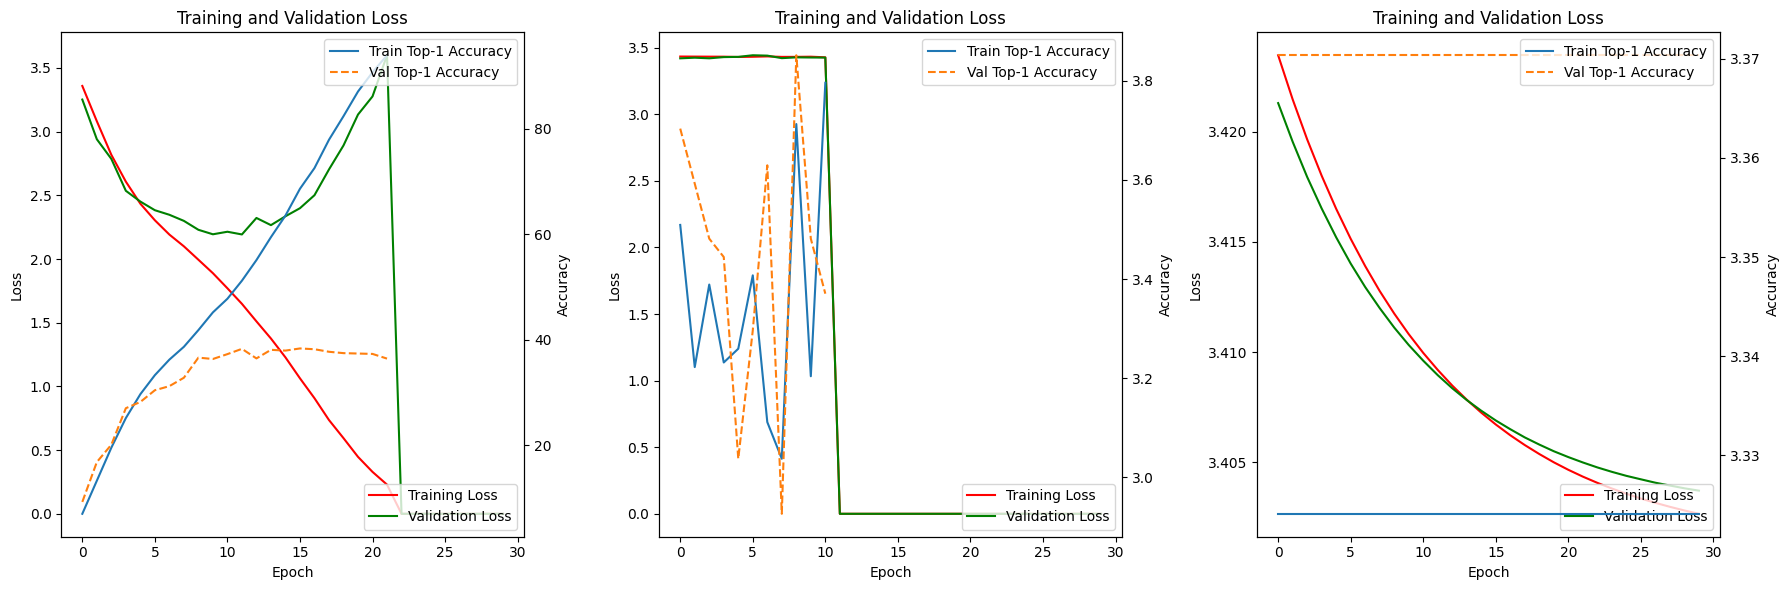

In [ ]:
show_subplots(data_list, 'cnnhyp')

### 3 Model testing [10 marks]
Online evaluation of your model performance on the test set.

> Prepare the dataloader for the testset.

> Write evaluation code for writing predictions.

> Upload it to Kaggle submission page (6 marks)


#### 3.1 Test class and predictions (4 marks)

> Build a test class, prepare a test dataloader and generate predictions

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set).

In [ ]:
# Your code here!

In [ ]:
cnnaug_pt = 'cnnaug.pt'
results_path = ROOT+'results/'+ cnnaug_pt
data_cnnaug_plt = torch.load(results_path, map_location=device)
net = CNN().to(device)
net.load_state_dict(data_cnnaug_plt['state_dict'])

<All keys matched successfully>

In [ ]:
class TestData(Dataset):
  def __init__(self, root_dir, transform):
    # Set the loading directory
    self.root_dir = root_dir
    self.transform = transform
    # List all images in folder and count them
    all_imgs = os.listdir(root_dir)
    self.total_imgs = natsorted(all_imgs)
  def __len__(self):
    # Return the previously computed number of images
    return len(self.total_imgs)
  def __getitem__(self, idx):
    img_loc = os.path.join(self.root_dir, self.total_imgs[idx])

    # Use PIL for image loading
    image = Image.open(img_loc).convert("RGB")
    # Apply the transformations
    tensor_image = self.transform(image)
    return tensor_image, self.total_imgs[idx]

In [ ]:
test_dataset = TestData(root_dir=ROOT + '/test_set', transform=trnsfrm)
test_dataloader = DataLoader(test_dataset, batch_size=24, shuffle=False, num_workers=2)

In [ ]:
for imgs,  names in test_dataloader:
    print("Batch of images has shape: ",imgs.shape)
    print("Batch of names has shape: ", names)

Batch of images has shape:  torch.Size([24, 3, 64, 64])
Batch of names has shape:  ('0a32f209_1b6e.JPEG', '0a130fb8_b027.JPEG', '0a547c95_69b1.JPEG', '0ad55c32_0758.JPEG', '0ae03fbb_5363.JPEG', '0ae02665_9b79.JPEG', '0b8fec4c_8a2e.JPEG', '0b2686b9_eea9.JPEG', '0b232170_5426.JPEG', '0bbf9645_b4e1.JPEG', '0bcded0d_65ef.JPEG', '0bf3f391_fb71.JPEG', '0c01c54d_7adb.JPEG', '0c7df704_13ce.JPEG', '0c26df4c_5166.JPEG', '0c604c60_2854.JPEG', '0ca9797d_2943.JPEG', '00cc0f59_c28c.JPEG', '0ce6f9d7_7b3a.JPEG', '0ce44a18_ee45.JPEG', '0ce7533b_7de5.JPEG', '0cf25cf9_9a7e.JPEG', '0d4f61e4_57e5.JPEG', '0d27512a_8511.JPEG')
Batch of images has shape:  torch.Size([24, 3, 64, 64])
Batch of names has shape:  ('0dc50700_484b.JPEG', '0dca6fe1_b5c9.JPEG', '0de291a9_6140.JPEG', '0df704a8_4380.JPEG', '0e2a2a81_5ff8.JPEG', '0e5cd4ca_be2f.JPEG', '0e5fe93b_cc58.JPEG', '0e08f7d3_b8c2.JPEG', '0e50e839_af59.JPEG', '0e697e09_9878.JPEG', '0e63903c_5e30.JPEG', '0eab4ca5_ca6c.JPEG', '0ed6a061_e373.JPEG', '0edb11a0_cfdd.JPE

In [ ]:
def predict(net, testloader):
  net.eval()

  predictions = []

  with torch.no_grad():
      for images, image_ids in testloader:
          images = images.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          predictions.extend(zip(image_ids, predicted.cpu().numpy()))

  with open('predictions1.csv', 'w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Id', 'Category'])
      for image_id, prediction in predictions:
          writer.writerow([image_id, prediction])

  print("")


In [ ]:
len(test_dataloader)

63

In [ ]:
predict(net, test_dataloader)

#### 3.2 Prepare your submission and upload to Kaggle  (6 marks)

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, e.g., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers. [To submit please click here.](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [6 marks].



### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [16 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task. You can perform fine-tuning in following fashion:

- Train an entire model: Start training model from scratch (large dataset, more computation)

- Train some layers, freeze others: Lower layer features are general (problem independent) while higher layer features are specific (problem dependent – freeze)

- Freeze convolution base and train only last FC layers (small dataset and lower computation)

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10`` [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here is only 10*


In [ ]:
# Your code here!
import torchvision
trnsfrms = transforms.Compose([
    transforms.Resize(224),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

# Load the datasets
train_CIF_set = torchvision.datasets.CIFAR10(
    root=ROOT+'data',
    train=True,
    download=True,
    transform=trnsfrms
)

train_CIF_loader = torch.utils.data.DataLoader(
    train_CIF_set,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

Files already downloaded and verified


In [ ]:
train_CIF_size = int(0.8 * len(train_CIF_set))
val_CIF_size = len(train_CIF_set) - train_CIF_size

trCIF_dataset, valCIF_dataset = random_split(train_CIF_set, [train_CIF_size, val_CIF_size])

trCIF_loader = DataLoader(trCIF_dataset, batch_size=16, shuffle=True, num_workers=2)
valCIF_loader = DataLoader(valCIF_dataset, batch_size=24, shuffle=False, num_workers=2)

> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [ ]:
# Your code here!
import torchvision.models as models

# Loading the pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)
print(alexnet.classifier)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
def find_last_index(classifier):
    index = None
    for i, layer in enumerate(classifier):
        if isinstance(layer, nn.Linear):
            index = i
    return index

last_index = find_last_index(alexnet.classifier)
print(f"The index of the last linear layer is: {last_index}")

The index of the last linear layer is: 6


In [ ]:
# Modify the last fully connected layer to match the new number of categories
alexnet.classifier[last_index] = nn.Linear(alexnet.classifier[last_index].in_features, 10)
loss_alex = nn.CrossEntropyLoss()
optimizer_alex = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

#### 4.1 Apply transfer learning with pretrained model weights (6 marks)


> Configuration 1: No frozen layers

In [ ]:
# Your model changes here - also print trainable parameters

In [ ]:
alexnet_unfro = alexnet

In [ ]:
def print_param(alexnet):
  for name, param in alexnet.named_parameters():
    status = "Frozen" if not param.requires_grad else "No Frozen"
    print(f"{name} ({status}): {param.size()}")

In [ ]:
print_param(alexnet)

features.0.weight (No Frozen): torch.Size([64, 3, 11, 11])
features.0.bias (No Frozen): torch.Size([64])
features.3.weight (No Frozen): torch.Size([192, 64, 5, 5])
features.3.bias (No Frozen): torch.Size([192])
features.6.weight (No Frozen): torch.Size([384, 192, 3, 3])
features.6.bias (No Frozen): torch.Size([384])
features.8.weight (No Frozen): torch.Size([256, 384, 3, 3])
features.8.bias (No Frozen): torch.Size([256])
features.10.weight (No Frozen): torch.Size([256, 256, 3, 3])
features.10.bias (No Frozen): torch.Size([256])
classifier.1.weight (No Frozen): torch.Size([4096, 9216])
classifier.1.bias (No Frozen): torch.Size([4096])
classifier.4.weight (No Frozen): torch.Size([4096, 4096])
classifier.4.bias (No Frozen): torch.Size([4096])
classifier.6.weight (No Frozen): torch.Size([10, 4096])
classifier.6.bias (No Frozen): torch.Size([10])


In [ ]:
def alex_train(num, net, train_loader, val_loader, loss_fn, optimizer, patience, save_path, topk):
  nepochs = num #number of epochs
  #patience
  best_val_loss = np.inf
  patience_counter = 0

  saveCkpt_cnn = save_path

  # record performance
  # store the mean loss in each epoch
  losses, losses_val = np.zeros(nepochs), np.zeros(nepochs)

  # Store top-k accuracy for each epoch
  topk_accuracy_epochs, topk_accuracy_epochs_val = {k: [] for k in topk}, {k: [] for k in topk}

  #to work with gpu
  net = net.to(device)

  for epoch in range(nepochs):
    running_loss = 0.0   # accumulated loss
    n = 0                # number of minibatches
    all_outputs = []
    all_targets = []
    for data in train_loader:
      inputs, labels = data
      #to work with gpu you will need to load data and labels to gpu
      inputs = inputs.to(device)
      labels = labels.to(device)
      #labels = labels.squeeze()
      #labels = labels.squeeze(dim=1)
      #labels = torch.squeeze(labels)
      # Zero the parameter gradients
      optimizer.zero_grad()
      # Forward, backward, and update parameters
      outputs = net(inputs).to(device) # note: .to(device) helps to load data to your gpu
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      # accumulate loss
      running_loss += loss.item()
      n += 1
      # Accumulate outputs and targets
      all_outputs.append(outputs)
      all_targets.append(labels)

    # Concatenate all outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # topk_accuracy and losses for this epoch in the training
    # Compute top-k accuracy
    topk_acc = topk_accuracy(all_outputs, all_targets, topk=topk)
    for i, k in enumerate(topk):
      topk_accuracy_epochs[k].append(topk_acc[i].item())# Convert tensors to numbers
    # record the mean loss for this epoch
    losses[epoch] = running_loss / n # return? or save to device

    # topk_accuracy and losses for this epoch in the testing
    loss_val, topk_acc_val = stats_alex(val_loader, net, loss_fn, topk=topk)
    for i, k in enumerate(topk):
      topk_accuracy_epochs_val[k].append(topk_acc_val[i].item())# item():Convert tensors to numbers
    losses_val[epoch] = loss_val

    #maybe another method
    if loss_val < best_val_loss:
      best_val_loss = loss_val
      patience_counter = 0
      #save : torch.save(net.state_dict(), 'best_model.pt') # if nothing changed one time would be fine
      statsrec_cnn = {
          'train_losses': losses,
          'val_losses': losses_val,
          'train_topk': topk_accuracy_epochs,
          'val_topk': topk_accuracy_epochs_val,
      }
      torch.save({
          "state_dict": net.state_dict(),
          "stats": statsrec_cnn
          }, saveCkpt_cnn)
      #losses_end = np.vstack([losses, losses_val])
      #topk_end = np.vstack([topk_accuracy_epochs, topk_accuracy_epochs_val])
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print("Training stopped.")
        break
  #losses_end = np.vstack([losses, losses_val])
  #topk_end = np.vstack([topk_accuracy_epochs, topk_accuracy_epochs_val])
  statsrec_cnn = {
          'train_losses': losses,
          'val_losses': losses_val,
          'train_topk': topk_accuracy_epochs,
          'val_topk': topk_accuracy_epochs_val,
      }
  torch.save({
          "state_dict": net.state_dict(),
          "stats": statsrec_cnn
          }, saveCkpt_cnn)

In [ ]:
def stats_alex(loader, net, loss_fn, topk=(1,)):
  net.eval()
  all_outputs = []
  all_targets = []
  correct = 0
  total = 0
  running_loss = 0
  n = 0    # counter for number of minibatches
  with torch.no_grad():
    for data in loader:
      images, labels = data

      #to work with gpu you will need to load data and labels to gpu
      images = images.to(device)
      labels = labels.to(device)
      #labels = labels.squeeze(dim=1)
      outputs = net(images).to(device)

      # accumulate loss
      running_loss += loss_fn(outputs, labels)
      n += 1

      # Accumulate outputs and targets
      all_outputs.append(outputs)
      all_targets.append(labels)

    # Concatenate all outputs and targets
    # Convert them to tensor as one-dimensional
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute top-k accuracy
    topk_acc = topk_accuracy(all_outputs, all_targets, topk=topk)

  return running_loss/n, topk_acc

In [ ]:
alex_train(30, alexnet, trCIF_loader, valCIF_loader, loss_alex, optimizer_alex, 10, ROOT+'results/' + 'alexunfro.pt', topk=(1,))

Training stopped.


#### 4.2 Fine-tuning model with frozen layers (6 marks)

> Configuration 2: Frozen base convolution blocks

In [ ]:
# Your changes here - also print trainable parameters
alexnet_fro = alexnet
for param in alexnet.features.parameters():
    param.requires_grad = False

In [ ]:
print_param(alexnet_fro)

features.0.weight (Frozen): torch.Size([64, 3, 11, 11])
features.0.bias (Frozen): torch.Size([64])
features.3.weight (Frozen): torch.Size([192, 64, 5, 5])
features.3.bias (Frozen): torch.Size([192])
features.6.weight (Frozen): torch.Size([384, 192, 3, 3])
features.6.bias (Frozen): torch.Size([384])
features.8.weight (Frozen): torch.Size([256, 384, 3, 3])
features.8.bias (Frozen): torch.Size([256])
features.10.weight (Frozen): torch.Size([256, 256, 3, 3])
features.10.bias (Frozen): torch.Size([256])
classifier.1.weight (No Frozen): torch.Size([4096, 9216])
classifier.1.bias (No Frozen): torch.Size([4096])
classifier.4.weight (No Frozen): torch.Size([4096, 4096])
classifier.4.bias (No Frozen): torch.Size([4096])
classifier.6.weight (No Frozen): torch.Size([10, 4096])
classifier.6.bias (No Frozen): torch.Size([10])


In [ ]:
alex_train(30, alexnet_fro, trCIF_loader, valCIF_loader, loss_alex, optimizer_alex, 10, ROOT+'results/' + 'alexfro.pt', topk=(1,))

Training stopped.


#### 4.3 Compare above configurations and comment on performances. (4 marks)

In [ ]:
# Your graphs here and please provide comment in markdown in another cell

In [ ]:
data_list_alex = []

In [ ]:
alexunfro_pt = 'alexunfro.pt'
results_path = ROOT+'results/'+ alexunfro_pt
data_alexunfro_plt = torch.load(results_path, map_location=device)
data_list_alex.append(data_alexunfro_plt)

In [ ]:
alexfro_pt = 'alexfro.pt'
results_path = ROOT+'results/'+ alexfro_pt
data_alexfro_plt = torch.load(results_path, map_location=device)
data_list_alex.append(data_alexfro_plt)

Comments : With the images below, we can make a few points.

Firstly, the trends in both models are the same.

Secondly, in terms of detail, the fluctuations are greater without the use of a freezing layer.

Then, in terms of accuracy, using a frozen layer is a bit higher. In terms of Loss, both have val_loss close to 0.

From the above data, it is proved that the use of frozen layer can effectively prevent the loss of this valuable prior knowledge during training. Such an operation ensures that the model maintains a stable performance when there is a high accuracy.

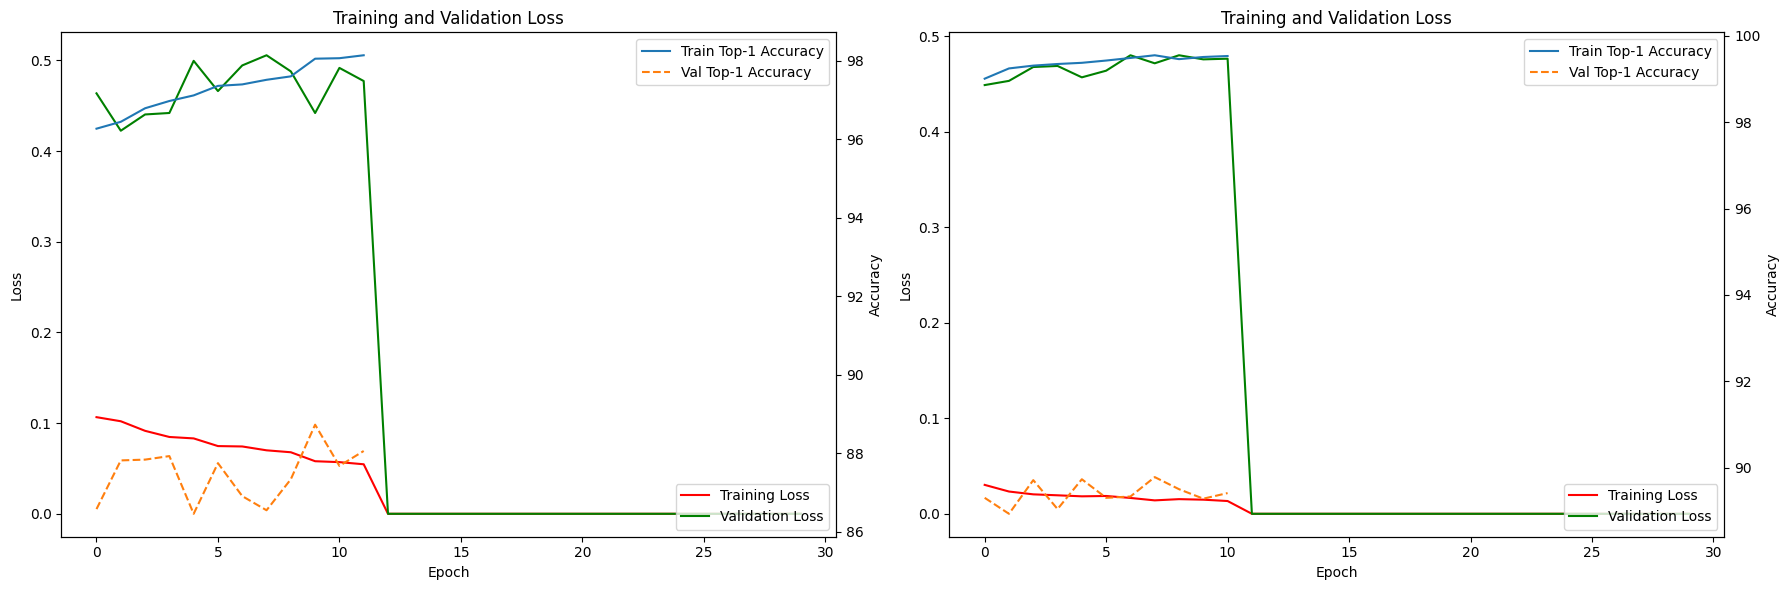

In [ ]:
show_subplots(data_list_alex, 'alex')

##### Thank you for completing the assessment - if you have any question, please ask on teams channel or attend lab sessions on Tuesdays and Wednesdays.

That's what part one is all about.